In [153]:
import json
import pandas as pd
import numpy as np
import re
import nltk
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [154]:
!pip install biopython

In [0]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy  
from sklearn.metrics import calinski_harabaz_score
from Bio.Cluster import kcluster 

In [0]:
with open('train.json', encoding='utf-8') as f:
    d = json.load(f)
    f.close()

data_all = pd.DataFrame(d)

In [157]:
def num_ingre_each_recipe(list_ingrs_each_recipe):
    '''
    This method is to count the number of ingredients of each recipe
    '''
    return len(list_ingrs_each_recipe)


data_all['num_ingredients_contained'] = data_all['ingredients'].apply(
    num_ingre_each_recipe)
print(data_all.shape)  # the total amount of data is 39774

(39774, 4)


In [0]:
# Only choose the recipes containing more than 3 ingres.
data_all = data_all[data_all.num_ingredients_contained >= 3]

In [0]:
# there are some special words like numbers are meaningless.
# Hence, the first thing is to remove these from the datasets.
# other consideration can all be solved by sklearn package
# (Make sure the word is in lower case; Delete symbols; Delete letters standing alone; Delete double spaces)

numbers = re.compile(r"\d")   # the Regular Expression of numbers
seven_up = re.compile(r"^7\sUp")  # the Regular Expression of '7 Up'


def datasets_cleaning(list_input):
    for string in range(len(list_input)):
        list_input[string] = re.sub(numbers, "", list_input[string])
        list_input[string] = re.sub(seven_up, "7up", list_input[string])
    return list_input


data_all['ingredients'] = data_all['ingredients'].apply(datasets_cleaning)

In [162]:
dict_cuisine = {}
for key in ytrain:
    dict_cuisine[key] = dict_cuisine.get(key, 0) + 1
print(dict_cuisine)  # the distribution of cuisine in ytrain

{'southern_us': 3394, 'mexican': 5157, 'british': 636, 'filipino': 605, 'italian': 6209, 'thai': 1196, 'jamaican': 418, 'french': 2081, 'greek': 951, 'japanese': 1130, 'brazilian': 379, 'moroccan': 633, 'irish': 540, 'indian': 2417, 'spanish': 795, 'cajun_creole': 1224, 'chinese': 2163, 'vietnamese': 656, 'korean': 677, 'russian': 386}


In [163]:
# balance recipes to ensure each cuisine has the same number of recipes(379)
cuisine = np.unique(y_all)
rows = min(dict_cuisine.values())
data = []
for i in range(20):
    d = data_all[data_all['cuisine']==cuisine[i]].sample(rows)
    data.append(d)
data_balance = pd.concat(data)
data_balance.shape

(7580, 4)

In [0]:
# then we want to split the name of each ingredients into several single words.
def tokenize_list(list_input):
    new_list = [val.split(" ") for val in list_input]
    list_get = [item for sublist in new_list for item in sublist]
    return list_get


data_train['ingre_splited'] = data_train['ingredients'].apply(tokenize_list)

In [0]:
# there are lot of similar words after spliting the name of ingredients like "apple" and "apples"
# we use stemming algorithm to get the same stem

from nltk.stem import PorterStemmer
porter = PorterStemmer()


def token_stemming(list_input):
    list_get = [porter.stem(word) for word in list_input]
    return list_get


# we use this method to update our splited words and then combine them into a sentence.
data_train['ingre_splited'] = data_train['ingre_splited'].apply(token_stemming)
data_train['ingre_string'] = data_train['ingre_splited'].str.join(' ')

In [0]:
# we generate the corpus based on the train data.
list_corpus = data_train['ingre_string'].tolist()

In [0]:
# Some words are stop words like 'a' 'is' 'or' 'not', we can then delete them from features
# Some words are meaningless adj., we can also delete them
# Some words are the brand names of ingredient, we can delete them as well

# add these meaningless words into the set of stop words, deleting all of them in the following TD-IDF model


def add_deleted_words():
    '''
    Some words are stop words like 'a' 'is' 'or' 'not', we can then delete them from features
    Some words are meaningless adj., we can also delete them
    Some words are the brand names of ingredient, we can delete them as well
    add these meaningless words into the set of stop words, deleting all of them in the following TD-IDF model
    '''

    # Here are all the words I(Quentin) could find to try and simplify the ingredient names
    list_delete_words = ["fat", "free", "oz", "fine", "finely", "superfine", "crushed", "crush", "cut", "up", "age",
                   "fashioned", "press", "refined", "squeeze", "refrigerated", "smoked", "sweet", "diced", "processed",
                   "nonfat", "packed", "firmly", "loosely", "gluten", "low", "high", "less", "sodium", "reduced",
                   "organic", "store bought", "of", "the", "semi", "condensed", "whole", "reduced", "light", "softened"
                   "ground", "fresh", "black", "natural", "flavored", "plain", "unsweetened", "vegan", "nonfat"]
    list_delete_words = tokenize_list(list_delete_words) # Split the Brand names.
    
    # All the brand names I(Quentin) found, we should delete the partial names including the name of ingredient.
    # for example, we only delete "Vay" rather than"Soy Vay",  delete "bell" rather than"Taco bell"
    Brand_names = ["Bertolli", "Crocker", "Conimex", "Colman", "Crystal Farms", "DeLallo", "Domino",
                   "Doritos", "Earth Balance", "Elmlea", "Estancia", "Fisher", "Flora", "Foster Farms",
                   "Gourmet Garden", "Goya", "Green Giant", "Heinz", "Hellmann", "Hidden Valley",
                   "Honeysuckle White", "Imperial", "JOHNSONVILLE", "Jack Daniels", "Johnsonville",
                   "Jimmy Dean", "KRAFT", "Knorr", "Lipton", "Manischewitz", "McCormick", "Mazola",
                   "Old El Paso", "Pillsbury", "Progresso", "Pure Wesson", "Ragu", "San Marzano",
                   "Sargento", "Vay", "Spice Islands", "BELL", "Truvía", "Uncle Ben",
                   "Velveeta", "Wish Bone", "Yoplait", "Zatarain", "Best Food", "Breyers",
                   "Campbell", "Hidden Valley", "Knorr", "McCormick", "Mizkan", "Progresso",
                   "Frank", "Red Gold"]
    
    Brand_names = tokenize_list(Brand_names) # Split the Brand names.
    Brand_names = [Brand_names[i].lower() for i in range(len(Brand_names))]  # lower case brand names
    
    # The following is the original codes, the problem is that the list_of_words[i] is actually a sing word
    #------------------------------------------------------------------------------------------------------
    # which can not match full words of brand, so we need to also split the brand names into single words.
    #def RemoveWords(list_of_words):
        #for i in range(len(list_of_words)):
            #for word_remove in dict_remove:          
                #list_of_words[i]  = re.sub("\\b" + word_remove + "\\b", "", list_of_words[i]) #Only match full words
        #return(list_of_words)
    #unique_words = RemoveWords(unique_words)
    #------------------------------------------------------------------------------------------------------

    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    #  use package including all stop words as part of our words waited for deleting

    list_delete_words = list_delete_words + Brand_names + [string for string in ENGLISH_STOP_WORDS]
    
    list_delete_words_stem = [porter.stem(word) for word in list_delete_words]
    
    list_delete_words = list_delete_words + list_delete_words_stem
    
    return sorted(list(set(list_delete_words)))

delete_words = add_deleted_words()

In [0]:
vectorizer = TfidfVectorizer(stop_words=delete_words) # it comes from the built-in method in skilearn. TD-IDF

In [170]:
vectorizer.fit(list_corpus)
# from the output of this code, we can see the some defult setting
# lowercase==True means it will automatically transform all sing words into lower case
# token_pattern='(?u)\\b\\w\\w+\\b' means it will only contain the words rather than a sing letter or some special symbol.

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['a', 'about', 'abov', 'above', 'across', 'after', 'afterward', 'afterwards', 'again', 'against', 'age', 'all', 'almost', 'alon', 'alone', 'along', 'alreadi', 'already', 'also', 'although', 'alway', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'ani', 'anoth', 'an...'would', 'yet', 'yoplait', 'you', 'your', 'yours', 'yourself', 'yourselv', 'yourselves', 'zatarain'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [171]:
vector = vectorizer.transform(data_train['ingre_string'])
feature_names = np.array(vectorizer.get_feature_names())
print(feature_names)
print(len(feature_names)) # count how many feature we constructed by the bag of words model(TD-IDF).

['abalon' 'abbamel' 'absinth' ... 'ziti' 'zucchini' 'épice']
2415


In [172]:
sorted_by_idf = np.argsort(vectorizer.idf_) 
# get the index of features which are ordered by their idf values

print(feature_names[sorted_by_idf[:30]]) 
# idf values means how frequent it exists in recipes. now we present the most frequent 30 features.

# As these features are so common that it may make a little contribution to the prediction.
# We consider to delete them by adding these features into our customized stop words.

for word in feature_names[sorted_by_idf[:30]]:
    delete_words.append(word)

['salt' 'oil' 'pepper' 'garlic' 'onion' 'ground' 'oliv' 'sugar' 'sauc'
 'tomato' 'chicken' 'water' 'chees' 'butter' 'flour' 'egg' 'clove'
 'powder' 'chop' 'dri' 'juic' 'chili' 'veget' 'cilantro' 'milk' 'rice'
 'cream' 'ginger' 'lemon' 'corn']


In [173]:
# again, we generate the features using TD-IDF
vectorizer = TfidfVectorizer(stop_words = delete_words)
vectorizer.fit(list_corpus)

Xtrain = vectorizer.transform(data_train['ingre_string']).toarray()
feature_names = np.array(vectorizer.get_feature_names())
print(feature_names)
print(len(feature_names)) # count how many feature we constructed by the bag of words model(TD-IDF).

['abalon' 'abbamel' 'absinth' ... 'ziti' 'zucchini' 'épice']
2385


In [174]:
data_balance['ingre_splited'] = data_balance['ingredients'].apply(tokenize_list)
data_balance['ingre_splited'] = data_balance['ingre_splited'].apply(token_stemming)
data_balance['ingre_string'] = data_balance['ingre_splited'].str.join(' ')
X_bla= vectorizer.transform(data_balance['ingre_string']).toarray()
X_bla

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

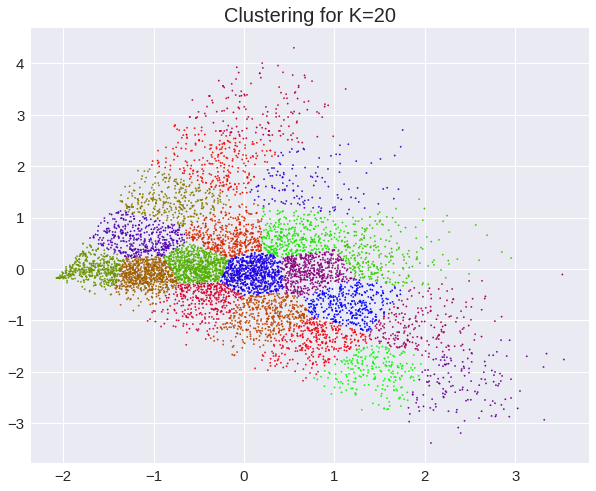

<Figure size 576x396 with 0 Axes>

In [175]:
# using Euclidean distance
svd = TruncatedSVD(n_components=2)
X_bla_svd = svd.fit(X_bla).transform(X_bla)
X_bla_std = StandardScaler().fit_transform(X_bla_svd)
kmeans = KMeans(n_clusters=20,max_iter=100) 
label = kmeans.fit_predict(X_bla_std) 
fig = plt.subplots(figsize=(10, 8))
plt.title('Clustering for K=20',size=20)
plt.tick_params(labelsize=15)
plt.scatter(X_bla_std[:, 0], X_bla_std[:, 1], c=label, s=2,cmap='brg')
plt.show()
plt.savefig('kmeansbla20.png')

In [0]:
# using Cosine distance
X_bla_std = StandardScaler().fit_transform(X_bla)
kmeans = kcluster(X_bla_std,nclusters=20,dist='u') 

In [0]:
vv = []
for i in range(20):
    index = np.where(kmeans[0]==i)
    value = data_balance.iloc[index]['cuisine'].value_counts()
    v = value.sort_index()
    vv.append(v)
final_value = pd.concat(vv,axis=1).fillna(0)    
areas = np.sort(np.unique(y_all))
upper_areas = [s.capitalize() for s in areas]


In [0]:
max_value = final_value.max(axis=0)
cui = final_value.idxmax()
column_sum = final_value.sum(axis=0)
Largest_prop = max_value/column_sum
lp = pd.DataFrame({'Proportion':list(Largest_prop)},index=list(cui))

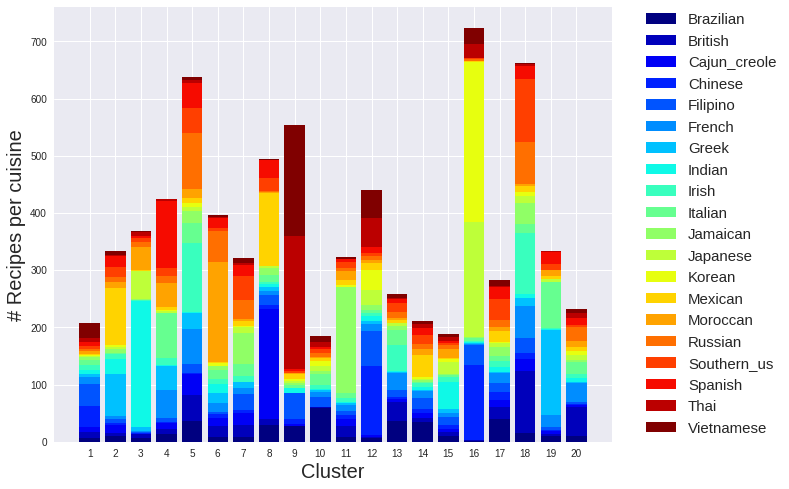

In [180]:
n = 20
colors = plt.cm.jet(np.linspace(0,1,n))
fig = plt.subplots(figsize=(10,8))
x = np.arange(1,21)
x_ticks = np.arange(1,21)
plt.xticks(x_ticks)
plt.ylabel('# Recipes per cuisine',size=20)
plt.xlabel('Cluster',size=20)
plt.tick_params(labelsize=10)
plt.bar(x,np.array(final_value.iloc[0]),color=colors[0])
for i in range(1,20):
    plt.bar(x,np.array(final_value.iloc[i]),bottom=sum(np.array(final_value.iloc[0:i])),color=colors[i])
plt.legend(upper_areas,bbox_to_anchor=(1.05,1.0),borderaxespad = 0.,prop={'size':15})

In [0]:
# internal evaluation
svd = TruncatedSVD(n_components=2)
X_bla_svd = svd.fit(X_bla).transform(X_bla)
X_bla_std = StandardScaler().fit_transform(X_bla_svd)
scores = []
for k in range(2,26):
    kmeans = KMeans(n_clusters=k,max_iter=100).fit(X_bla_std) 
    score = calinski_harabaz_score(X_bla_std,kmeans.labels_)
    scores.append(score)
X = range(2,26)
plt.xlabel('k')
plt.ylabel('calinski_harabaz_score')
plt.title('Calinski-Harabaz index evaluation')
plt.plot(X,scores,'o-')
plt.show()